Данные имеют следующий вид:

    Clothing ID: id одежды
    Age: возраст клиента
    Title: заголовок отзыва по продукту
    Review Text: отзыв по продукту
    Rating: рейтинг продукта от 1 (худшее) до 5 (лучшее)
    Recommended IND: Бинарная переменная указывающая рекомендует ли клиент данный продукт (1) или нет (0)
    Positive Feedback Count: Количество клиентов, нашедших данный продукт хорошим
    Division Name, Department Name, Class Name - категории и подкатегории продукта
    
**_Rating_** - целевая переменная (y), которую требуется предсказывать по имеющимся характеристикам

train.csv - датасет для обучения
<br>
test.csv - датасет для теста, на котором будет производиться вычисление итоговой метрики, результаты предсказанного рейтинга на данном датасате необходимо прислать в csv формате (см. ниже)

Тестируемая метрика: **accuracy**

В качестве решения задания требуется прислать csv файл, а также ноутбук с решением задачи
<br>
Формат файла: Rating (один столбец). Пример см. ниже
<br>
Название файла: Surname_Name_#group.csv (Ivanov_Ivan_316.csv)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
import string

from sklearn.cluster import  AgglomerativeClustering

from category_encoders import OrdinalEncoder
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import re
import pymorphy2
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from nltk.util import ngrams
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Маша\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
data = pd.read_csv("data/train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22311 entries, 0 to 22310
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              22311 non-null  int64 
 1   Age                      22311 non-null  int64 
 2   Title                    18669 non-null  object
 3   Review Text              21516 non-null  object
 4   Rating                   22311 non-null  int64 
 5   Recommended IND          22311 non-null  int64 
 6   Positive Feedback Count  22311 non-null  int64 
 7   Division Name            22297 non-null  object
 8   Department Name          22297 non-null  object
 9   Class Name               22297 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


In [3]:
print(data.isnull().sum())
df = data.copy()
df = df.fillna("")
print(df.isnull().sum())

Clothing ID                   0
Age                           0
Title                      3642
Review Text                 795
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64


In [4]:
list(df)

['Clothing ID',
 'Age',
 'Title',
 'Review Text',
 'Rating',
 'Recommended IND',
 'Positive Feedback Count',
 'Division Name',
 'Department Name',
 'Class Name']

In [5]:
# Кодирование для того чтобы попробовать посмотреть зависимость между признаками
df['Division Name'] = OrdinalEncoder().fit_transform(df['Division Name'])
df['Department Name'] = OrdinalEncoder().fit_transform(df['Department Name'])
df['Class Name'] = OrdinalEncoder().fit_transform(df['Class Name'])

<AxesSubplot:>

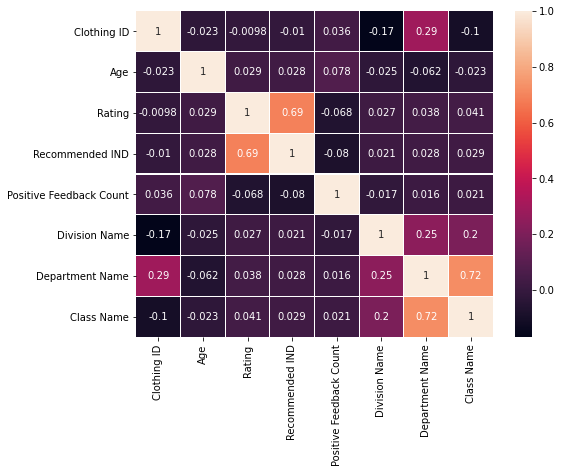

In [6]:
corr = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr,annot=True, linewidths=.1)
# Посмотрим, какие переменные влияют на Rating

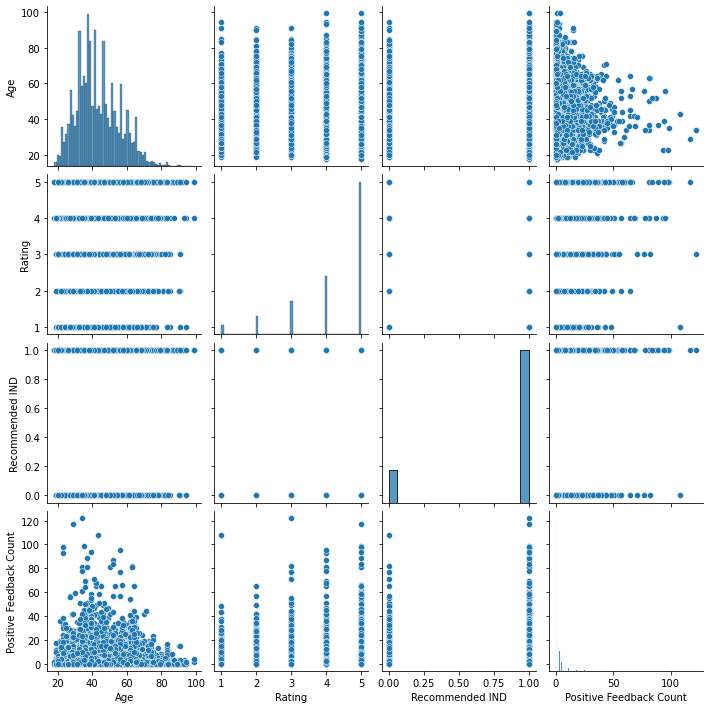

In [7]:
research = data[['Age', 'Rating', 'Recommended IND', 'Positive Feedback Count']].copy()
sns.pairplot(research)

In [8]:
agclust = AgglomerativeClustering(n_clusters=None, distance_threshold=1).fit(research)

In [9]:
def plot_silhouette_score_agl(df):
    silhouette_sc = []
    for k in range(2, 10):
        agl = AgglomerativeClustering(n_clusters=k).fit(df)
        yhat_agl = agl.labels_
        silhouette_sc.append(silhouette_score(df, yhat_agl))
        print(f'k = {k} silh = ', round(silhouette_sc[k-2],4) )
    
    
    plt.plot(range(2, 10), silhouette_sc, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$\Phi_0$')

In [11]:
# from sklearn.metrics import silhouette_score
# plot_silhouette_score_agl(research)

In [ ]:
agclust4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster = agclust4.fit_predict(research)

yhat_agclust5 = agclust4.labels_

research['label_agclust'] = cluster

In [ ]:
sns.pairplot(research, hue='label_agclust', palette='bright')

In [ ]:
research[research['label_agclust']==0].describe()

In [ ]:
research[research['label_agclust']==1].describe()

In [ ]:
research[research['label_agclust']==2].describe()

In [ ]:
research[research['label_agclust']==3].describe()

In [ ]:
# Каких-то явных отличий этих групп я не вижу
# Исходя из матрицы корреляции и попытки кластеризации получается, что особого влияния эти признаки не имеют

In [12]:
columns = list(df)
target = df['Rating']
df['Review'] = df['Title'] + ' ' + df['Review Text']
# Recommended IND наиболее влияющий на Rating признак
df = df[['Review', 'Recommended IND', 'Age', 'Rating']].copy()
df.head(5)

,Review,Recommended IND,Age,Rating
0,Great top! I got this top in an xs and the fit...,1,47,5
1,This poncho is very pretty and unique.it does...,1,54,4
2,Gorgeous lace! I was so pleased to receive thi...,1,34,5
3,Summer/fall wear I first spotted this on an re...,1,56,5
4,New favorite summer blouse The details on this...,1,66,5


In [13]:
def preprocess_text_in_columns(series_column, stop_words):

    series_column = series_column.str.lower()
    
    for i, text in series_column.iteritems():
        
        #drop emails
        text = re.sub('\S*@\S*\s?', '', text)
        # Remove distracting single quotes
        text = re.sub("\'", "", text)
        #keep only letters
        text = re.sub('[^a-z]', ' ', text)
        
        #drop whitespaces
        text = ' '.join(text.split())
        #text = text.strip()
        
        list_words = text.split(' ')
        
        tokens = [word for word in list_words if word not in stop_words]
        
        #Лемматезация слов
        word_net_lemmatizer = WordNetLemmatizer()
        lemmatizer = nltk.stem.WordNetLemmatizer()
        new_list_words = [word_net_lemmatizer.lemmatize(word, pos='v') for word in tokens]
        
        #morph = pymorphy2.MorphAnalyzer()
        #new_list_words = [morph.parse(word)[0].normal_form for word in tokens]
       
        text = ' '.join(new_list_words)
        series_column[i] = text
        
    return series_column

In [14]:
# Другая функция преобразования текста, которая возвращает лист из всех слов
def preprocessing(series_column, stop_words):

    full = []
    for i, text in series_column.iteritems():
        
        text = text.lower()
        
        #drop emails
        text = re.sub('\S*@\S*\s?', '', text)
        # Remove distracting single quotes
        text = re.sub("\'", "", text)
        #keep only letters
        text = re.sub('[^a-z]', ' ', text)
        
        #drop whitespaces
        text = ' '.join(text.split())
        #text = text.strip()
        
        list_words = text.split(' ')
        
        tokens = [word for word in list_words if word not in stop_words]
        
        #Лемматезация слов
        word_net_lemmatizer = WordNetLemmatizer()
        lemmatizer = nltk.stem.WordNetLemmatizer()
        new_list_words = [word_net_lemmatizer.lemmatize(word, pos='v') for word in tokens]
        
        #morph = pymorphy2.MorphAnalyzer()
        #new_list_words = [morph.parse(word)[0].normal_form for word in tokens]
       
        #text = ' '.join(new_list_words)
        #series_column[i] = text
        #series_column[i] = new_list_words
        for word in new_list_words:
            full.append(word)
            
    return  full

In [ ]:
# Можно посмотреть на n граммы слов и понять, что нужно рассматривать не по 1 слову а по 2 для более точного определения
# А еще у меня просто ничего не работало, если брать 1-граммы.

In [15]:
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

In [16]:
def gramfreq(text,n,num):
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

In [17]:
def gram_table(data, gram, length):
    out = pd.DataFrame(index=None)
    
    preprocessed = preprocessing(data, stop_words)
    
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessed,i,length).reset_index())
        table.columns = [f"{i}-Gram",f"{i}-Occurrence"]
        out = pd.concat([out, table], axis=1)
    return out

In [444]:
print("Non-Recommended Items")
non_rec = gram_table(data= df['Review'][df["Recommended IND"].astype(int) == 0], gram=[1,2,3,4,5], length=30)

Non-Recommended Items


In [445]:
non_rec

,1-Gram,1-Occurrence,2-Gram,2-Occurrence,3-Gram,3-Occurrence,4-Gram,4-Occurrence,5-Gram,5-Occurrence
0,look,2367,look like,459,really want love,80,really want love dress,19,want love really want love,5
1,dress,2122,want love,336,want love dress,73,look like maternity top,16,cold water lay flat dry,4
2,like,1918,go back,310,make look like,53,really want like dress,10,make look like football player,4
3,fit,1852,make look,236,really want like,47,really want love top,10,fit true size match model,3
4,top,1713,really want,174,fit true size,40,really want like top,10,true size match model photos,3
5,size,1570,run small,168,sadly go back,31,want love want love,9,wear medium photos reference measurements,3
6,love,1408,think would,135,want love top,30,make look like pregnant,6,fit really want love dress,3
7,fabric,1300,love dress,130,way much fabric,27,look like im wear,6,wash cold water hang dry,3
8,would,1253,didnt work,125,look like maternity,27,make feel like wear,5,want like really want like,3
9,wear,1201,run large,123,one go back,24,unfortunately one go back,5,size small usually wear size,2


In [446]:
print("Recommended Items")
rec = gram_table(data= df['Review'][df["Recommended IND"].astype(int) == 1], gram=[1,2,3,4,5], length=30)

Recommended Items


In [447]:
rec

,1-Gram,1-Occurrence,2-Gram,2-Occurrence,3-Gram,3-Occurrence,4-Gram,4-Occurrence,5-Gram,5-Occurrence
0,dress,11059,true size,1204,fit true size,440,compliment every time wear,49,get compliment every time wear,24
1,love,10249,fit perfectly,999,love love love,238,look great skinny jeans,29,cant say enough good things,10
2,fit,9830,look great,873,cant wait wear,213,get compliment every time,28,would say run true size,10
3,size,8935,love dress,860,run true size,208,love love love dress,27,receive compliment every time wear,9
4,wear,8595,love love,679,receive many compliment,164,size small fit perfectly,25,look great skinny jeans leggings,8
5,top,7313,look like,658,size fit perfectly,142,dress fit true size,23,size xl fit true size,8
6,great,6866,love top,629,small fit perfectly,134,receive many compliment wear,22,fyi c broad shoulder back,8
7,look,6746,run large,609,get many compliment,130,love love love love,22,lbs c curvy muscular frame,7
8,color,6254,well make,566,fit like glove,129,love love love top,20,many compliment every time wear,7
9,like,5676,usually wear,562,usually wear size,112,order usual size fit,19,many compliment first day wear,6


Дальше начинается предсказание

In [18]:
def Change_f (data, ngram, max_df, min_df):
    #vect = CountVectorizer(stop_words='english',analyzer='word', ngram_range=ngram, max_df = max_df, min_df = min_df)
    vect = TfidfVectorizer(stop_words='english',analyzer='word', ngram_range=ngram, max_df = max_df, min_df = min_df)
    df_text = vect.fit_transform(data)
    print(vect.get_feature_names())
    df_text = pd.DataFrame(df_text.toarray(), columns= vect.get_feature_names())
    return df_text

In [19]:
# Создание столбца с преобразованным текстом
df['preproc'] = preprocess_text_in_columns(df['Review'], stop_words)

In [20]:
df_text_n1 = Change_f(df['preproc'], (1, 1), 1., 0.02)

['absolutely', 'actually', 'add', 'adorable', 'amaze', 'area', 'arm', 'beautiful', 'best', 'better', 'big', 'bite', 'black', 'blouse', 'blue', 'body', 'boot', 'boxy', 'bra', 'bust', 'button', 'buy', 'casual', 'chest', 'color', 'come', 'comfortable', 'comfy', 'compliment', 'cut', 'cute', 'day', 'decide', 'definitely', 'denim', 'design', 'didnt', 'different', 'disappoint', 'doesnt', 'dont', 'drape', 'dress', 'easily', 'easy', 'end', 'especially', 'expect', 'extra', 'fabric', 'fall', 'favorite', 'feel', 'felt', 'feminine', 'figure', 'fine', 'fit', 'flatter', 'flow', 'flowy', 'fun', 'glad', 'good', 'gorgeous', 'great', 'green', 'hang', 'happy', 'heavy', 'hem', 'high', 'hips', 'hit', 'hop', 'huge', 'id', 'im', 'isnt', 'issue', 'ive', 'jacket', 'jeans', 'know', 'lace', 'large', 'larger', 'layer', 'lbs', 'leggings', 'length', 'light', 'lightweight', 'like', 'line', 'little', 'long', 'longer', 'look', 'loose', 'lot', 'love', 'lovely', 'low', 'make', 'material', 'maybe', 'medium', 'model', 'nav

In [21]:
df_text_n1

,absolutely,actually,add,adorable,amaze,area,arm,beautiful,best,better,...,way,wear,weight,white,wide,winter,wish,work,worth,xs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.339603,0.000000,0.0,0.0,0.000000,0.000000,0.312986
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.224955,0.000000,...,0.0,0.100073,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143691,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162267,0.000000,0.000000,...,0.0,0.235742,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.102014,0.0,0.000000,0.000000,0.0,0.0,0.155804,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
22307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.132758,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
22308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.232793,0.000000,0.000000,...,0.0,0.169102,0.0,0.000000,0.367769,0.0,0.0,0.000000,0.000000,0.582671
22309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.270856,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.317366,0.000000


In [17]:
df_text_n2 = Change_f(df['preproc'], (2, 2), 1., 0.007)

['absolutely love', 'arm hole', 'beautiful color', 'beautiful dress', 'better person', 'bite large', 'body type', 'broad shoulder', 'buy color', 'buy dress', 'buy size', 'color beautiful', 'color great', 'color love', 'comfortable wear', 'cute dress', 'didnt work', 'dont think', 'dress beautiful', 'dress dress', 'dress fit', 'dress great', 'dress look', 'dress love', 'dress make', 'dress perfect', 'dress run', 'dress wear', 'easy wear', 'fabric nice', 'fabric soft', 'fall winter', 'feel like', 'fell love', 'felt like', 'fit better', 'fit fine', 'fit flatter', 'fit great', 'fit like', 'fit nicely', 'fit perfect', 'fit perfectly', 'fit true', 'fit tts', 'flatter fit', 'form fit', 'good quality', 'great color', 'great dress', 'great fit', 'great quality', 'high quality', 'highly recommend', 'hit right', 'im glad', 'im lbs', 'im sure', 'im usually', 'lbs order', 'length perfect', 'light weight', 'like dress', 'like model', 'like picture', 'like wear', 'little big', 'little bite', 'little l

In [20]:
df_text_n3 = Change_f(df['preproc'], (3, 3), 1., 0.002)

['absolutely love dress', 'compliment time wear', 'dress buy dress', 'dress fit perfectly', 'dress love dress', 'dress run large', 'fabric super soft', 'feel like wear', 'fit like dream', 'fit like glove', 'fit like model', 'fit true size', 'great skinny jeans', 'im lbs order', 'im usually size', 'local retailer store', 'look better person', 'look forward wear', 'look great jeans', 'look like maternity', 'look like model', 'look like picture', 'love love dress', 'love love love', 'make feel like', 'make look like', 'medium fit perfectly', 'normally wear size', 'order normal size', 'order regular size', 'order size small', 'order usual size', 'really want like', 'really want love', 'receive lot compliment', 'reference im lbs', 'run bite large', 'run large im', 'run large order', 'run large size', 'run little big', 'run little large', 'run little small', 'run true size', 'size fit great', 'size fit perfect', 'size fit perfectly', 'size medium fit', 'size small fit', 'size usually wear', 

In [616]:
#df_text = Change_f(df['preproc'], (1, 2), 1., 0.009)

In [21]:
X = df[['Recommended IND', 'Age']].copy()
y = df['Rating']

X[list(df_text_n1)] = df_text_n1
X[list(df_text_n2)] = df_text_n2
X[list(df_text_n3)] = df_text_n3

In [20]:
#X[list(df_text)] = df_text

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [23]:
y_pred = RandomForestClassifier().fit(X_train, y_train).predict(X_test)

In [26]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6484427515124356
              precision    recall  f1-score   support

           1       0.31      0.09      0.14       149
           2       0.33      0.20      0.25       300
           3       0.45      0.48      0.46       557
           4       0.50      0.16      0.25       953
           5       0.72      0.96      0.82      2504

    accuracy                           0.65      4463
   macro avg       0.46      0.38      0.38      4463
weighted avg       0.60      0.65      0.59      4463



In [27]:
dataTest = pd.read_csv("data/test.csv")

In [28]:
dfTest = dataTest.copy()
dfTest = dfTest.fillna("")
dfTest.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

In [29]:
dfTest['Review'] = dfTest['Title'] + ' ' + dfTest['Review Text']
dfTest = dfTest[['Review', 'Recommended IND', 'Age']].copy()

In [30]:
dfTest['preproc'] = preprocess_text_in_columns(dfTest['Review'], stop_words)

In [31]:
df_test_n1 = Change_f(dfTest['preproc'], (1, 1), 1., 0.02)

['absolutely', 'actually', 'add', 'adorable', 'agree', 'amaze', 'area', 'arm', 'arrive', 'beautiful', 'best', 'better', 'big', 'bite', 'black', 'blouse', 'blue', 'body', 'boot', 'boxy', 'bra', 'bust', 'button', 'buy', 'cardigan', 'casual', 'chest', 'color', 'come', 'comfortable', 'comfy', 'compliment', 'cool', 'cotton', 'cut', 'cute', 'dark', 'day', 'decide', 'definitely', 'design', 'didnt', 'different', 'disappoint', 'doesnt', 'dont', 'drape', 'dress', 'easily', 'easy', 'end', 'especially', 'expect', 'extra', 'fabric', 'fall', 'favorite', 'feel', 'felt', 'feminine', 'figure', 'fine', 'fit', 'flatter', 'flow', 'flowy', 'frame', 'fun', 'glad', 'good', 'gorgeous', 'great', 'green', 'grey', 'hang', 'happy', 'hem', 'high', 'highly', 'hips', 'hit', 'hop', 'huge', 'id', 'im', 'isnt', 'issue', 'ive', 'jacket', 'jeans', 'kind', 'knee', 'knit', 'know', 'lace', 'large', 'larger', 'layer', 'lbs', 'leggings', 'length', 'light', 'lightweight', 'like', 'line', 'little', 'long', 'longer', 'look', 'lo

In [38]:
df_test_n2 = Change_f(dfTest['preproc'], (2, 2), 1., 0.007)

['absolutely love', 'arm hole', 'beautiful color', 'beautiful dress', 'beautiful love', 'bite large', 'blue color', 'body type', 'broad shoulder', 'buy color', 'buy dress', 'cami underneath', 'color beautiful', 'color great', 'color love', 'color perfect', 'comfortable flatter', 'cute love', 'didnt like', 'didnt work', 'doesnt look', 'dont like', 'dont think', 'dress comfortable', 'dress dress', 'dress fit', 'dress great', 'dress look', 'dress love', 'dress make', 'dress perfect', 'dress run', 'dress wear', 'easy wear', 'fabric beautiful', 'fabric nice', 'fabric soft', 'fall winter', 'feel like', 'fell love', 'felt like', 'fit better', 'fit flatter', 'fit great', 'fit like', 'fit look', 'fit perfect', 'fit perfectly', 'fit true', 'flatter dress', 'flatter love', 'form fit', 'good quality', 'great buy', 'great color', 'great dress', 'great fall', 'great fit', 'great quality', 'great summer', 'high quality', 'highly recommend', 'im glad', 'im lbs', 'im sure', 'im usually', 'ive wear', 'l

In [37]:
df_test_n3 = Change_f(dfTest['preproc'], (3, 3), 1., 0.002)

['absolutely love dress', 'buy regular size', 'color absolutely beautiful', 'compliment time wear', 'dress fit perfectly', 'dress look great', 'dress love dress', 'dress make look', 'dress run small', 'dress true size', 'fall winter spring', 'fit great buy', 'fit like glove', 'fit like model', 'fit perfectly im', 'fit true size', 'flatter look great', 'great color great', 'great dress wear', 'great layer piece', 'great shirt love', 'great skinny jeans', 'hit right place', 'hug right place', 'im lbs buy', 'im lbs size', 'im long waisted', 'im months pregnant', 'im usually size', 'im usually xs', 'ive receive compliment', 'large usually wear', 'lay flat dry', 'lbs buy xs', 'lbs dd waist', 'leggings skinny jeans', 'light airy perfect', 'like reviewers say', 'little black dress', 'little large fit', 'look better person', 'look cute jeans', 'look great black', 'look great jeans', 'look great leggings', 'look great skinny', 'look like maternity', 'look like picture', 'look like wear', 'look 

In [615]:
#df_test = Change_f(dfTest['preproc'], (2, 2), 1., 0.005)

In [39]:
X = df[['Recommended IND', 'Age']].copy()
y = df['Rating']

XTest = dfTest[['Recommended IND', 'Age']].copy()

for name in df_text_n1:
    if name in df_test_n1:
        X[name] = df_text_n1[name]
        XTest[name] = df_test_n1[name]
        
for name in df_text_n2:
    if name in df_test_n2:
        X[name] = df_text_n2[name]
        XTest[name] = df_test_n2[name]

for name in df_text_n3:
    if name in df_test_n3:
        X[name] = df_text_n3[name]
        XTest[name] = df_test_n3[name]
        

X = X.fillna(0) 
XTest = XTest.fillna(0)

In [604]:
# X = df[['Recommended IND', 'Age']].copy()
# y = df['Rating']

# XTest = dfTest[['Recommended IND', 'Age']].copy()

# for name in df_text:
#     if name in df_test:
#         X[name] = df_text[name]
#         XTest[name] = df_test[name]
        

# X = X.fillna(0) 
# XTest = XTest.fillna(0)

In [40]:
y_final = RandomForestClassifier().fit(X, y).predict(XTest)

In [624]:
DataPredict = pd.DataFrame( data = { 'y_final' : y_final}, columns = ['y_final'])

In [625]:
DataPredict.to_csv('DataPredict_MaryIzo')

In [41]:
dff = dfTest[['Review','Recommended IND']].copy()

In [42]:
dff['Rating'] = y_final

In [35]:
df['Rating'].value_counts()/len(df)

5    0.560441
4    0.215230
3    0.123347
2    0.065618
1    0.035364
Name: Rating, dtype: float64

In [43]:
dff['Rating'].value_counts()/len(dff)

5    0.745532
3    0.135319
4    0.057021
2    0.051915
1    0.010213
Name: Rating, dtype: float64

In [44]:
for i in range(len(dff)):
    print(dff['Review'][i])
    print(dff['Recommended IND'][i])
    print(dff['Rating'][i])

Beautiful, but does not fit as pictured Saw this dress in the blue motif and thought it would be perfect for a summer outdoor wedding. i'm 5'4" 125 lbs and ordered a size 2. it fit true to size in the shoulders, bust and length, but did not fit as pictured on the site; it looks in the pictures like there is some shape to the waistline without being too fitted, which i like. on me there was absolutely no shape. it just billowed and looked really maternity. 15 bucks for alterations to take in the sides and now it's my favorite darn thin
1
5
 I can not imagine the cut in the waist being flattering on anyone. i ordered an xs and an xxs still would have flared too much in the waste. i ignored the previous review and that was a huge mistake!
0
2
 
1
5
So chic! This is a wow! so chic...reminds of something i would have bought in paris. worth every penny. even my husband loves it on me...his words were "it's a standout". i work in the design industry so i am always looking for something that r

1
5
 It was hard for me to pay full price for basic white button-down but i am so glad i did. the high-low and split back detail give the shirt a unique look. it looks cute with jeans and wedges as a dressed down option. i bought this to go with the shoreline skirt and it looked really good together. this is a staple that can be worn multiple times and for many years.
1
5
Not colorfast! I'm so bummed! i absolutely loved the pair of these i bought in the bronze color great fit, great color, so comfortable! however, i just washed them and could tell right away when i laid them flat to dry that they had lost color in areas where they had wrinkled in the wash machine. so, now they have strange lighter lines running along them. not acceptable. 

i will say that the two lighter colors may not have this issue. for reference, see my stats. i bought a 26.
0
2
Fell in love years late I fell in love with this dress two years after it sold out so i'm so lucky to have gotten my greedy little hands 